In [27]:
import librosa, librosa.display, os
import IPython.display as ipd, numpy as np, matplotlib.pyplot as plt
from madmom.features import DBNDownBeatTrackingProcessor, RNNDownBeatProcessor
from eval import beatTracker
from utils import load_annot
import seaborn as sns

In [28]:
audio_dir = "/Users/caspia/Desktop/Github/BallroomData/"
annot_dir = "/Users/caspia/Desktop/Github/BallroomAnnotations-master/"

## Load Audio

In [29]:
# bad case
# audio_file = os.path.join(audio_dir, 'VienneseWaltz/Media-104211.wav')
# annot_file = os.path.join(annot_dir, 'Media-104211.beats')

# good case
audio_file = os.path.join(audio_dir, 'VienneseWaltz/Albums-Ballroom_Classics4-12.wav')
annot_file = os.path.join(annot_dir, 'Albums-Ballroom_Classics4-12.beats')

In [30]:
x, sr = librosa.load(audio_file)
ipd.Audio(x, rate=sr)

## Ground Truth

In [56]:
beat_info_gt = load_annot(annot_file)
beats_gt = beat_info_gt[:, 0]
mask = (beat_info_gt[:, 1] == 1)
downbeats_gt = beat_info_gt[mask, 0]

In [57]:
beat_clicks = librosa.clicks(beats_gt, sr=sr, length=len(x))
downbeat_clicks = librosa.clicks(downbeats_gt, sr=sr, length=len(x), click_freq=2000)
ipd.Audio(x + beat_clicks + downbeat_clicks, rate=sr)

## My Model

In [58]:
beats, downbeats = beatTracker(audio_file)

In [59]:
beat_clicks = librosa.clicks(beats, sr=sr, length=len(x))
downbeat_clicks = librosa.clicks(downbeats, sr=sr, length=len(x), click_freq=2000)
ipd.Audio(x + beat_clicks + downbeat_clicks, rate=sr)

# madmom

In [31]:
db_proc = DBNDownBeatTrackingProcessor(beats_per_bar=[2, 3, 4], fps=100)
act = RNNDownBeatProcessor()(audio_file)
beat_info = db_proc(act)

/Users/caspia/anaconda3/envs/beat/lib/python3.7/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)
/Users/caspia/anaconda3/envs/beat/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [33]:
act.shape

(3179, 2)

In [9]:
beats_mm = beat_info[:, 0]
mask = (beat_info[:, 1] == 1)
downbeats_mm = beat_info[mask, 0]

In [10]:
beat_clicks = librosa.clicks(beats_mm, sr=sr, length=len(x))
downbeat_clicks = librosa.clicks(downbeats_mm, sr=sr, length=len(x), click_freq=2000)
ipd.Audio(x + beat_clicks + downbeat_clicks, rate=sr)

# Plots

## bad case

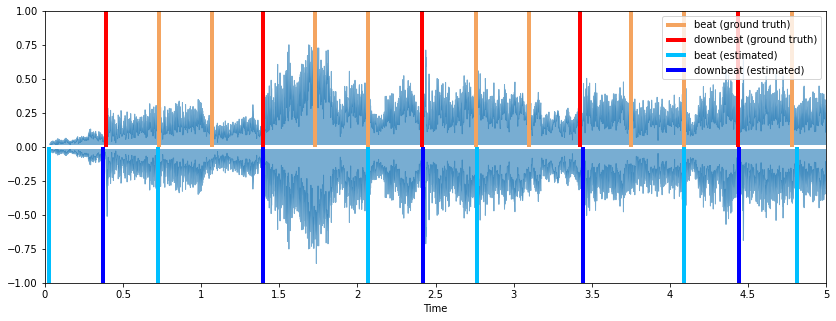

In [35]:
# audio_file = '/Users/caspia/Desktop/Github/BallroomData/VienneseWaltz/Media-104211.wav'
# annot_file = '/Users/caspia/Desktop/Github/BallroomAnnotations-master/Media-104211.beats'
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, alpha=0.6, label='_nolegend_')
plt.hlines(0, 30, 0, color='w', linewidth=4.0, label='_nolegend_')

# ground truth
plt.vlines(beats_gt, 0, 1, color='sandybrown', linewidth=4.0)
plt.vlines(downbeats_gt, 0, 1, color='r', linewidth=4.0)
# predicted
plt.vlines(beats, -1, 0, color='deepskyblue', linewidth=4.0)
plt.vlines(downbeats, -1, 0, color='b', linewidth=4.0)

plt.ylim(-1, 1)
plt.xlim(0, 5)
plt.legend(['beat (ground truth)', 'downbeat (ground truth)', 'beat (estimated)', 'downbeat (estimated)'])
plt.savefig('figs/badcase.png')

## good case

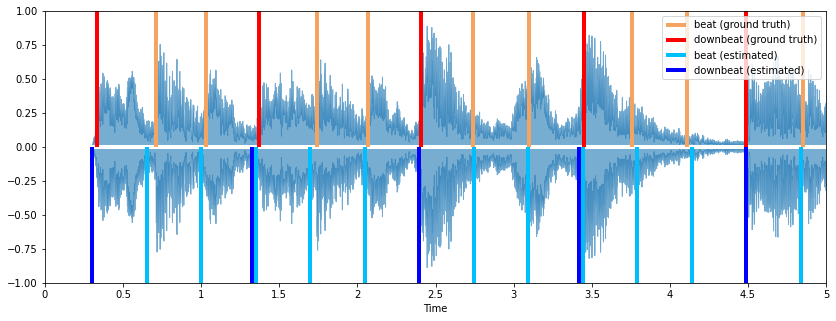

In [43]:
# audio_file = '/Users/caspia/Desktop/Github/BallroomData/Rumba-International/Albums-Pais_Tropical-09.wav'
# annot_file = '/Users/caspia/Desktop/Github/BallroomAnnotations-master/Albums-Pais_Tropical-09.beats'
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, alpha=0.6, label='_nolegend_')
plt.hlines(0, 30, 0, color='w', linewidth=4.0, label='_nolegend_')

# ground truth
plt.vlines(beats_gt, 0, 1, color='sandybrown', linewidth=4.0)
plt.vlines(downbeats_gt, 0, 1, color='r', linewidth=4.0)
# predicted
plt.vlines(beats, -1, 0, color='deepskyblue', linewidth=4.0)
plt.vlines(downbeats, -1, 0, color='b', linewidth=4.0)

plt.ylim(-1, 1)
plt.xlim(0, 5)
plt.legend(['beat (ground truth)', 'downbeat (ground truth)', 'beat (estimated)', 'downbeat (estimated)'])
plt.savefig('figs/goodcase.png')

# visualize the output from network

In [52]:
from model import BeatTrackingModel, eval_audio_transforms
import torch
import torch.nn as nn
import utils

hparams = {
        "n_cnn_layers": 2,
        "n_rnn_layers": 3,
        "rnn_dim": 25,
        "n_class": 2,
        "n_feats": 8,
        "dropout": 0.1,
        "stride": 1,
        "input_sample": 220500,
        "batch_size": 1
}

model = BeatTrackingModel(
        hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
        hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout'], hparams['input_sample']
)
state = utils.load_model(model, None, "checkpoints/checkpoint_best", False)

y, _ = utils.load(audio_file, sr=44100, mono=True)
y = torch.Tensor(y)

y = eval_audio_transforms(y)
y = nn.utils.rnn.pad_sequence(y, batch_first=True).unsqueeze(1).transpose(2, 3)

# Predict
all_outputs = model(y)
_, total_length, num_classes = all_outputs.shape

song_pred = all_outputs.reshape(-1, num_classes)
beats_pred = torch.sigmoid(song_pred[:total_length, 0]).data.numpy()
downbeats_pred = torch.sigmoid(song_pred[:total_length, 1]).data.numpy()

## bad case

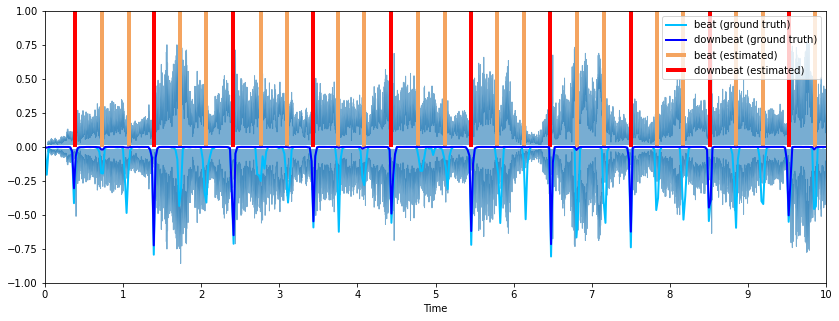

In [53]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, alpha=0.6, label='_nolegend_')
plt.hlines(0, 30, 0, color='w', linewidth=4.0, label='_nolegend_')

# ground truth
plt.vlines(beats_gt, 0, 1, color='sandybrown', linewidth=4.0)
plt.vlines(downbeats_gt, 0, 1, color='r', linewidth=4.0)

resolution = 1024 / 44100
time_stamps = np.arange(len(beats_pred)) * resolution
# predicted
plt.plot(time_stamps, -beats_pred, color='deepskyblue', linewidth=2.0)
plt.plot(time_stamps, -downbeats_pred, color='b', linewidth=2.0)

plt.ylim(-1, 1)
plt.xlim(0, 10)
plt.legend(['beat (ground truth)', 'downbeat (ground truth)', 'beat (estimated)', 'downbeat (estimated)'])
plt.savefig('figs/activation_bad.png')

## good case

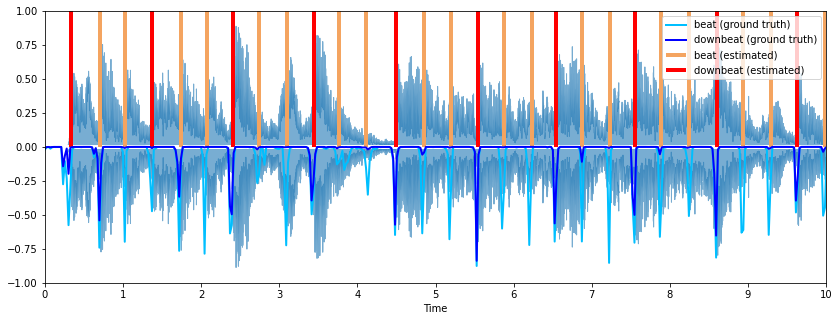

In [45]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, alpha=0.6, label='_nolegend_')
plt.hlines(0, 30, 0, color='w', linewidth=4.0, label='_nolegend_')

# ground truth
plt.vlines(beats_gt, 0, 1, color='sandybrown', linewidth=4.0)
plt.vlines(downbeats_gt, 0, 1, color='r', linewidth=4.0)

resolution = 1024 / 44100
time_stamps = np.arange(len(beats_pred)) * resolution
# predicted
plt.plot(time_stamps, -beats_pred, color='deepskyblue', linewidth=2.0)
plt.plot(time_stamps, -downbeats_pred, color='b', linewidth=2.0)

plt.ylim(-1, 1)
plt.xlim(0, 10)
plt.legend(['beat (ground truth)', 'downbeat (ground truth)', 'beat (estimated)', 'downbeat (estimated)'])
plt.savefig('figs/activation_good.png')

# Style-wise Evaluation

(0.5, 1.1)

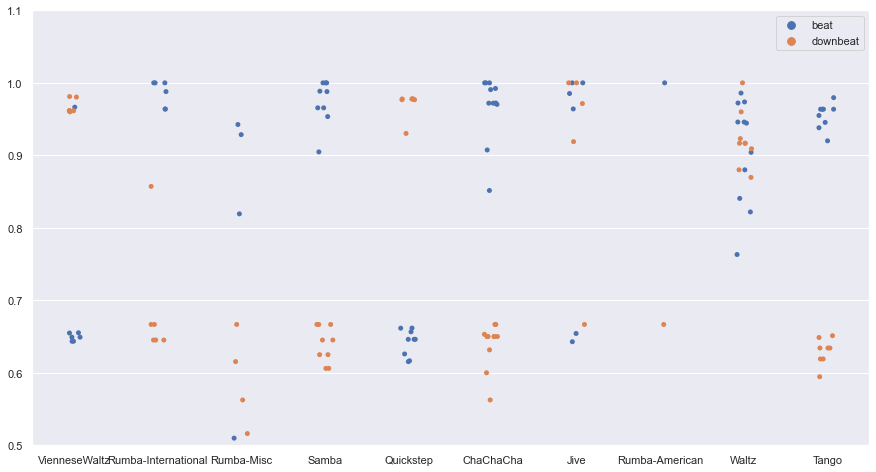

In [26]:
f_style = {'VienneseWaltz': [0.6548672566371682, 0.6551724137931034, 0.6434782608695652, 0.6491228070175439, 0.6491228070175439, 0.9664429530201343, 0.6434782608695652], 'Rumba-International': [0.9879518072289156, 0.963855421686747, 1.0, 0.963855421686747, 1.0, 1.0], 'Rumba-Misc': [0.9285714285714286, 0.5098039215686275, 0.8192771084337348, 0.9425287356321839], 'Samba': [0.9879518072289156, 0.9047619047619048, 1.0, 1.0, 1.0, 0.9655172413793104, 0.9885057471264368, 0.9534883720930233, 0.9655172413793104], 'Quickstep': [0.6461538461538462, 0.6564885496183206, 0.6461538461538462, 0.6153846153846153, 0.6615384615384614, 0.6616541353383459, 0.6461538461538462, 0.6165413533834586, 0.6259541984732825], 'ChaChaCha': [0.9074074074074074, 0.9719626168224299, 0.9906542056074767, 0.9702970297029703, 0.9922480620155039, 0.9719626168224299, 1.0, 0.9719626168224299, 0.9719626168224299, 1.0, 1.0, 0.8514851485148515], 'Jive': [0.6428571428571428, 1.0, 0.9852941176470589, 0.6542056074766355, 0.9640287769784173, 1.0], 'Rumba-American': [1.0], 'Waltz': [0.8219178082191781, 0.904109589041096, 0.9722222222222222, 0.9736842105263158, 0.7631578947368421, 0.9859154929577464, 0.8799999999999999, 0.9459459459459458, 0.9459459459459458, 0.9444444444444445, 0.8405797101449276], 'Tango': [0.9636363636363636, 0.92, 0.954954954954955, 0.9636363636363636, 0.9636363636363636, 0.9795918367346939, 0.9636363636363636, 0.9454545454545454, 0.9380530973451328]}
f_style_db = {'VienneseWaltz': [0.9803921568627451, 0.9811320754716981, 0.9615384615384615, 0.9615384615384615, 0.9615384615384615, 0.9600000000000001, 0.9615384615384615], 'Rumba-International': [0.6451612903225806, 0.8571428571428572, 0.6666666666666666, 0.6451612903225806, 0.6451612903225806, 0.6666666666666666], 'Rumba-Misc': [0.6666666666666666, 0.6153846153846153, 0.5161290322580645, 0.5625], 'Samba': [0.6666666666666666, 0.6060606060606061, 0.6451612903225806, 0.6451612903225806, 0.6666666666666666, 0.625, 0.625, 0.6666666666666666, 0.6060606060606061], 'Quickstep': [0.9777777777777777, 0.9777777777777777, 0.9767441860465117, 0.0, 0.9777777777777777, 0.9777777777777777, 0.9767441860465117, 0.2777777777777778, 0.9302325581395349], 'ChaChaCha': [0.65, 0.65, 0.6666666666666666, 0.631578947368421, 0.653061224489796, 0.65, 0.65, 0.6, 0.65, 0.5625, 0.6666666666666666, 0.47368421052631576], 'Jive': [0.918918918918919, 1.0, 0.6666666666666666, 0.9714285714285714, 0.4680851063829787, 1.0], 'Rumba-American': [0.6666666666666666], 'Waltz': [0.9166666666666666, 0.8695652173913043, 0.33333333333333337, 0.9230769230769231, 0.9166666666666666, 0.3448275862068966, 0.8799999999999999, 0.9166666666666666, 0.9600000000000001, 1.0, 0.9090909090909091], 'Tango': [0.6341463414634146, 0.5945945945945945, 0.6190476190476191, 0.6341463414634146, 0.0, 0.6486486486486487, 0.6341463414634146, 0.6190476190476191, 0.6511627906976745]}
xs = []
ys = []
ms = []
for style in f_style.keys():
    for v in f_style[style]:
        xs.append(style)
        ys.append(v)
        ms.append("beat")
for style in f_style_db.keys():
    for v in f_style_db[style]:
        xs.append(style)
        ys.append(v)
        ms.append("downbeat")

    
# bar plot
sns.set(rc={'figure.figsize':(15,8)})
sns.stripplot(x=xs, y=ys, hue=ms)
# plt.legend(loc='best', fontsize='15', labels=xs)
# ax.set_xticklabels(category_labels, size = 15)
plt.ylim([0.5,1.1])
# ax.set_yticklabels(ax.get_yticks(), size = 15)
# plt.savefig("harmonix_MOS.pdf")

(0.5, 1.1)

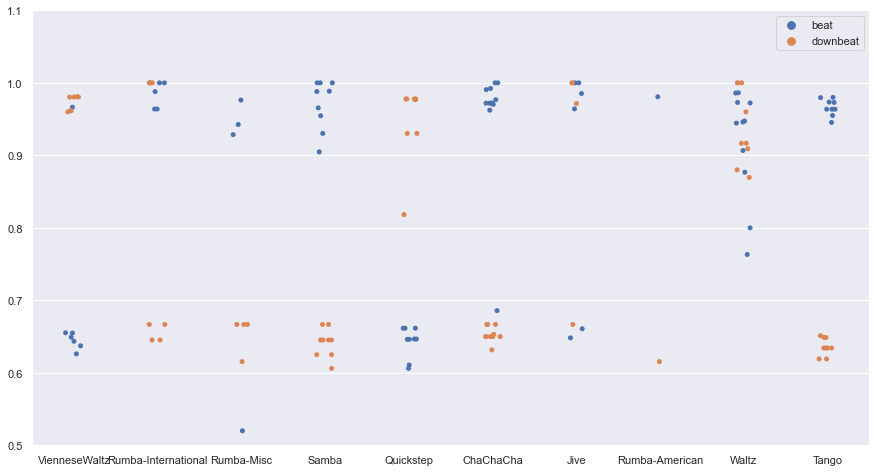

In [25]:
f_style = {'VienneseWaltz': [0.6548672566371682, 0.6551724137931034, 0.6434782608695652, 0.6491228070175439, 0.6491228070175439, 0.9664429530201343, 0.6434782608695652], 'Rumba-International': [0.9879518072289156, 0.963855421686747, 1.0, 0.963855421686747, 1.0, 1.0], 'Rumba-Misc': [0.9285714285714286, 0.5098039215686275, 0.8192771084337348, 0.9425287356321839], 'Samba': [0.9879518072289156, 0.9047619047619048, 1.0, 1.0, 1.0, 0.9655172413793104, 0.9885057471264368, 0.9534883720930233, 0.9655172413793104], 'Quickstep': [0.6461538461538462, 0.6564885496183206, 0.6461538461538462, 0.6153846153846153, 0.6615384615384614, 0.6616541353383459, 0.6461538461538462, 0.6165413533834586, 0.6259541984732825], 'ChaChaCha': [0.9074074074074074, 0.9719626168224299, 0.9906542056074767, 0.9702970297029703, 0.9922480620155039, 0.9719626168224299, 1.0, 0.9719626168224299, 0.9719626168224299, 1.0, 1.0, 0.8514851485148515], 'Jive': [0.6428571428571428, 1.0, 0.9852941176470589, 0.6542056074766355, 0.9640287769784173, 1.0], 'Rumba-American': [1.0], 'Waltz': [0.8219178082191781, 0.904109589041096, 0.9722222222222222, 0.9736842105263158, 0.7631578947368421, 0.9859154929577464, 0.8799999999999999, 0.9459459459459458, 0.9459459459459458, 0.9444444444444445, 0.8405797101449276], 'Tango': [0.9636363636363636, 0.92, 0.954954954954955, 0.9636363636363636, 0.9636363636363636, 0.9795918367346939, 0.9636363636363636, 0.9454545454545454, 0.9380530973451328]}
f_style_db = {'VienneseWaltz': [0.9803921568627451, 0.9811320754716981, 0.9615384615384615, 0.9615384615384615, 0.9615384615384615, 0.9600000000000001, 0.9615384615384615], 'Rumba-International': [0.6451612903225806, 0.8571428571428572, 0.6666666666666666, 0.6451612903225806, 0.6451612903225806, 0.6666666666666666], 'Rumba-Misc': [0.6666666666666666, 0.6153846153846153, 0.5161290322580645, 0.5625], 'Samba': [0.6666666666666666, 0.6060606060606061, 0.6451612903225806, 0.6451612903225806, 0.6666666666666666, 0.625, 0.625, 0.6666666666666666, 0.6060606060606061], 'Quickstep': [0.9777777777777777, 0.9777777777777777, 0.9767441860465117, 0.0, 0.9777777777777777, 0.9777777777777777, 0.9767441860465117, 0.2777777777777778, 0.9302325581395349], 'ChaChaCha': [0.65, 0.65, 0.6666666666666666, 0.631578947368421, 0.653061224489796, 0.65, 0.65, 0.6, 0.65, 0.5625, 0.6666666666666666, 0.47368421052631576], 'Jive': [0.918918918918919, 1.0, 0.6666666666666666, 0.9714285714285714, 0.4680851063829787, 1.0], 'Rumba-American': [0.6666666666666666], 'Waltz': [0.9166666666666666, 0.8695652173913043, 0.33333333333333337, 0.9230769230769231, 0.9166666666666666, 0.3448275862068966, 0.8799999999999999, 0.9166666666666666, 0.9600000000000001, 1.0, 0.9090909090909091], 'Tango': [0.6341463414634146, 0.5945945945945945, 0.6190476190476191, 0.6341463414634146, 0.0, 0.6486486486486487, 0.6341463414634146, 0.6190476190476191, 0.6511627906976745]}
xs = []
ys = []
ms = []
for style in f_style.keys():
    for v in f_style[style]:
        xs.append(style)
        ys.append(v)
        ms.append("beat")
for style in f_style_db.keys():
    for v in f_style_db[style]:
        xs.append(style)
        ys.append(v)
        ms.append("downbeat")

    
# bar plot
sns.set(rc={'figure.figsize':(15,8)})
sns.stripplot(x=xs, y=ys, hue=ms)
# plt.legend(loc='best', fontsize='15', labels=xs)
# ax.set_xticklabels(category_labels, size = 15)
plt.ylim([0.5,1.1])
# ax.set_yticklabels(ax.get_yticks(), size = 15)
# plt.savefig("harmonix_MOS.pdf")